In [1]:
import struct as st
import numpy as np
import matplotlib.pyplot as plt

In this problem, we need to correctly classify MNIST images given their true labels, so this is a multi-class classification problem and the performance of a model is estimated by accuracy.

In [2]:
%matplotlib inline
def read_from_idx_files(file_path, images=True):
    with open(file_path,'rb') as f:
        magic, size = st.unpack(">II", f.read(8))
        if images:
            n_rows, n_cols = st.unpack(">II", f.read(8))
            data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
            data = data.reshape((size, n_rows, n_cols))
        else:
            data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    return data

Please note that the input files were uploaded to kaggle and the notebook was compiled using the kaggle kernel.

In [3]:
train = read_from_idx_files('/kaggle/input/mnist-ubyte/train-images.idx3-ubyte')
test = read_from_idx_files('/kaggle/input/mnist-ubyte/t10k-images.idx3-ubyte')
train_labels = read_from_idx_files('/kaggle/input/mnist-ubyte/train-labels.idx1-ubyte', images=False)
test_labels = read_from_idx_files('/kaggle/input/mnist-ubyte/t10k-labels.idx1-ubyte', images=False)

In [4]:
train.shape, test.shape

((60000, 28, 28), (10000, 28, 28))

In [5]:
train_labels.shape, test_labels.shape

((60000,), (10000,))

In [6]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

Plotting images to make sure whether we read the data properly

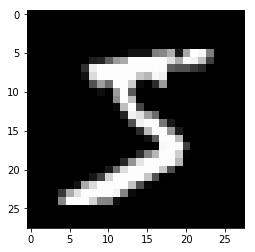

In [7]:
plt.imshow(train[0,:,:], cmap='gray')
plt.show()

Splitting data into training and validation data for model development and comparison

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
import pandas as pd

No. of Images per class 

In [10]:
pd.Series(train_labels).value_counts().sort_index()

0    5923
1    6742
2    5958
3    6131
4    5842
5    5421
6    5918
7    6265
8    5851
9    5949
dtype: int64

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(train, train_labels, test_size=10000, random_state=42)

In [12]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((50000, 28, 28), (10000, 28, 28), (50000,), (10000,))

As a part of the assignment, we will be compiling two models and compare the accuracies and then we will be predicting the labels of the test data using the best model

### SVM Classifier

Normalizing the input image so that pixel intensities will be in the range of 0 to 1

In [13]:
X_train = X_train / 255
X_valid = X_valid / 255

In [14]:
X_train.shape

(50000, 28, 28)

To employ Classification in SVM, we need to change the image into a 1d vector

In [15]:
X_train = X_train.reshape(X_train.shape[0], 28 * 28)
X_valid = X_valid.reshape(X_valid.shape[0], 28 * 28)

In [16]:
from sklearn.svm import SVC
clf = SVC(C=1, kernel='rbf', gamma='auto', random_state=42, decision_function_shape='ovo')

clf.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [17]:
y_pred = clf.predict(X_valid)

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

Training Accuracy

In [19]:
accuracy_score(y_train, clf.predict(X_train))

0.94056

Validation accuracy

In [20]:
accuracy_score(y_valid, y_pred)

0.9401

In [21]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], ha="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [22]:
confusion_mtx = confusion_matrix(y_valid, y_pred)

In [23]:
confusion_mtx

array([[ 954,    0,    5,    4,    3,    8,    2,    0,    7,    1],
       [   0, 1072,    7,    4,    1,    1,    1,    0,    6,    1],
       [   2,   10,  926,    6,   12,    5,   10,    8,   13,    2],
       [   4,    5,   16,  911,    0,   28,    1,    7,   21,    7],
       [   2,    2,    7,    0,  938,    1,    3,    3,    1,   23],
       [   8,   13,    5,   20,    9,  839,   12,    2,   10,    1],
       [   8,    1,    2,    0,    4,    8,  954,    0,    4,    0],
       [   2,   15,   14,    3,   11,    4,    0,  995,    4,   12],
       [   4,   12,    7,   19,    9,   23,    5,    4,  893,    3],
       [   4,    5,    7,   10,   31,    4,    0,   23,    7,  919]])

Inferences from Confusion Matrix:
1. images of 9 are misclassified as 4 and 7.
2. images of 7 are misclassified as 1 as does the images of 8
3. Also, images of 3 are misclassified as 5

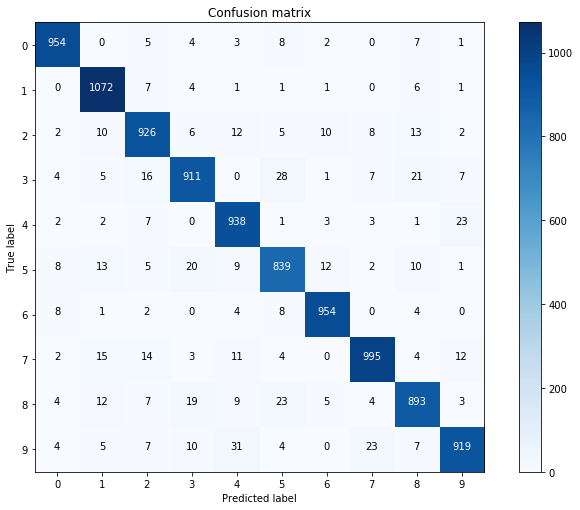

In [24]:
plt.figure(figsize = (10,7))
plot_confusion_matrix(confusion_mtx, classes = range(10))
plt.show()

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       984
           1       0.94      0.98      0.96      1093
           2       0.93      0.93      0.93       994
           3       0.93      0.91      0.92      1000
           4       0.92      0.96      0.94       980
           5       0.91      0.91      0.91       919
           6       0.97      0.97      0.97       981
           7       0.95      0.94      0.95      1060
           8       0.92      0.91      0.92       979
           9       0.95      0.91      0.93      1010

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



SVM Classifier has a decent accuracy, but let us explore to acheive accuracy more than it

### Convultion Neural Network

In [26]:
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(train, train_labels, test_size=10000, random_state=42)

In [28]:
X_train = X_train / 255
X_valid = X_valid / 255

In [29]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_valid = X_valid.reshape(X_valid.shape[0], 28, 28, 1)

In [30]:
y_train = to_categorical(y_train, num_classes = 10)
y_valid = to_categorical(y_valid, num_classes = 10)

In [31]:
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout

Here, we will be using a Convolution Neural Network with 2 Convolution layers, one with 32 filters and another with 64 filters, in the final layer, we used RELU activation to add non-linearity to the network. For the output layer, we used Softmax activation to determine probabalities for each class separately.

In [33]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [34]:
np.random.seed(42)

For the data augmentation, we used

* Rotation of some training images by 10 degrees
* Zooming by 10% for some training images
* shifting images horizontally by 10% of the width
* shifting  images vertically by 10% of the height

In [35]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False, 
        featurewise_std_normalization=False,
        samplewise_std_normalization=False, 
        zca_whitening=False,
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,
        vertical_flip=False)

In [36]:
epochs = 10
batch_size = 50

Using RMSprop Optimizer and with the ReduceLROnPlateau function from Keras callbacks, we choose to reduce the LR by half if the accuracy is not improved after 3 epochs.

In [37]:
from tensorflow.compat.v1.keras.optimizers import RMSprop
from tensorflow.compat.v1.keras.callbacks import ReduceLROnPlateau

In [38]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_valid, y_valid),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Train for 1000 steps, validate on 10000 samples
Epoch 1/10
1000/1000 - 53s - loss: 0.3726 - accuracy: 0.8817 - val_loss: 0.0620 - val_accuracy: 0.9807
Epoch 2/10
1000/1000 - 53s - loss: 0.1434 - accuracy: 0.9570 - val_loss: 0.0441 - val_accuracy: 0.9860
Epoch 3/10
1000/1000 - 52s - loss: 0.1130 - accuracy: 0.9665 - val_loss: 0.0374 - val_accuracy: 0.9880
Epoch 4/10
1000/1000 - 52s - loss: 0.1086 - accuracy: 0.9685 - val_loss: 0.0402 - val_accuracy: 0.9877
Epoch 5/10
1000/1000 - 53s - loss: 0.1036 - accuracy: 0.9706 - val_loss: 0.0381 - val_accuracy: 0.9877
Epoch 6/10
1000/1000 - 52s - loss: 0.1075 - accuracy: 0.9698 - val_loss: 0.0348 - val_accuracy: 0.9899
Epoch 7/10
1000/1000 - 52s - loss: 0.1086 - accuracy: 0.9700 - val_loss: 0.0364 - val_accuracy: 0.9903
Epoch 8/10
1000/1000 - 52s - loss: 0.1083 - accuracy: 0.9699 - val_loss: 0.0406 - val_accuracy: 0.9893
Epoch 9/10
1000/1000 - 52s - loss: 0.1107 - accuracy: 0.9698 - val_loss: 0.0452 - val_accuracy: 0.9886
Epoch 10/10
1000/1000 - 5

Plot to check the accuracies and loss of training and validation data per epoch

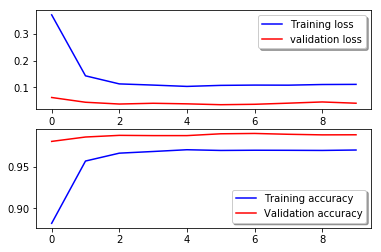

In [39]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [40]:
# Convert predictions classes to one hot vectors 
y_pred = np.argmax(model.predict(X_valid), axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_valid, axis = 1)

In [41]:
accuracy_score(y_true, y_pred)

0.9887

In [42]:
confusion_matrix(y_true, y_pred) 

array([[ 975,    0,    2,    0,    0,    0,    4,    0,    3,    0],
       [   1, 1079,   11,    0,    0,    0,    0,    2,    0,    0],
       [   0,    2,  983,    2,    0,    0,    0,    4,    2,    1],
       [   0,    0,    2,  994,    0,    3,    0,    0,    0,    1],
       [   0,    0,    0,    0,  975,    0,    0,    0,    0,    5],
       [   1,    0,    0,    3,    1,  904,    5,    0,    4,    1],
       [   0,    0,    0,    0,    1,    0,  977,    0,    3,    0],
       [   0,    0,    2,    0,    3,    0,    0, 1053,    2,    0],
       [   1,    0,    5,    1,    4,    1,    2,    2,  961,    2],
       [   1,    0,    0,    1,   10,    1,    0,    8,    3,  986]])

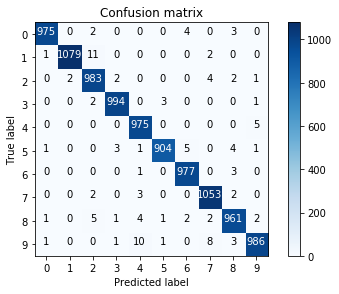

In [43]:
plot_confusion_matrix(confusion_matrix(y_true, y_pred) , classes = range(10))

The amount of misclassications have significantly decreased for 9s

In [44]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       984
           1       1.00      0.99      0.99      1093
           2       0.98      0.99      0.98       994
           3       0.99      0.99      0.99      1000
           4       0.98      0.99      0.99       980
           5       0.99      0.98      0.99       919
           6       0.99      1.00      0.99       981
           7       0.99      0.99      0.99      1060
           8       0.98      0.98      0.98       979
           9       0.99      0.98      0.98      1010

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



This model was way better than the SVM model, so finally using this to test it on our test data

In [45]:
test = test.reshape(test.shape[0], 28, 28, 1)
test = test / 255

In [46]:
test_predictions = model.predict(test)

In [47]:
test_predictions = np.argmax(test_predictions, axis = 1) 

In [48]:
accuracy_score(test_labels, test_predictions)

0.9911

In [49]:
print(classification_report(test_labels, test_predictions))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      1.00      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



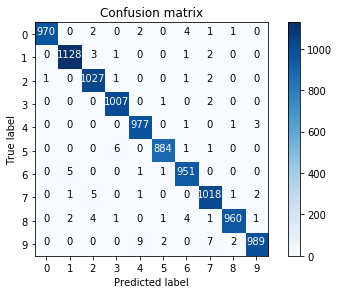

In [50]:
plot_confusion_matrix(confusion_matrix(test_labels, test_predictions) , classes = range(10))

Using our convolution neural network, we achieved an accuracy of 99.08% on the test data, so we will go with this model as our final model